In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV,train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,auc
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
path_out = r'C:\Users\karl\Documents\datasets'
df_churn = pd.read_csv(r'C:\Users\karl\Documents\datasets\Churn_Modelling.csv',sep=",")

In [3]:
def encode_ohe(df,numeric_cols,categorical_cols):
    """
    fonction qui permet d encoder les variables categorielles et de standardiser les variables numerique
    a travers un pipeline.    
    
    Parameters
    ----------
    df : TYPE dataframe
    numeric_cols : liste
        liste de nom de colonne de type numerique
    categorical_cols : liste
        liste de nom de colonne de type categorielle

    Returns
    -------
    ohe_encode_df : dataframe
        dataframe valeurs numeriques standardisees et colonnes categorielles encodees a chaud
        
    """
    numeric_transformer = Pipeline(steps=[
        ('imputer',SimpleImputer(strategy='constant',fill_value=0)),
        ('scaler',StandardScaler())
        ])
    
    categ_transformer = Pipeline(steps=[
        ('imputer',SimpleImputer(strategy='constant',fill_value='inconnue')),
        ('ohe',OneHotEncoder(handle_unknown='ignore'))
        ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num',numeric_transformer,numeric_cols),
            ('cat',categ_transformer,categorical_cols)
        ])
    
    preprocessor.fit(df)  # fit the ColumnTransformer object on the input data
    
    ohe_columns = list(preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_cols))
    new_columns = numeric_cols + ohe_columns
    ohe_encode_df = pd.DataFrame(preprocessor.transform(df), columns=new_columns)
    return ohe_encode_df 
def split_data(df,y_col):
    from sklearn.model_selection import train_test_split
    x_train,x_test,y_train,y_test = train_test_split(df.loc[:, ~df.columns.isin(y_col)],df[y_col],test_size=0.2,random_state=0,stratify=df[y_col])
    return x_train,x_test,y_train,y_test
def plot_roc_curves(models, X_train, y_train, X_test, y_test):
    
    #dans le cas ou on veut reentrainer les modeles pour la comparaison
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbes ROC pour plusieurs modèles')

    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label='Modèle %d (AUC = %0.2f)' % (i+1, roc_auc))

    plt.legend(loc="lower right")
    plt.show()
    
def one_stat_result(model, x_train, y_train, x_test, y_test,b_seuil_label=False):
    train_predictions = model.predict(x_train.to_numpy())
    test_predictions = model.predict(x_test.to_numpy())
    if b_seuil_label==True:
        train_predictions = (train_predictions>=0.5).astype(int)
        test_predictions = (test_predictions>=0.5).astype(int)
    print("test_predictions:")
    print(test_predictions)
    # Calculer l'erreur de validation
    validation_error = np.mean(np.abs(train_predictions - y_train.values))
    print("Calculer l'erreur de validation:")
    print(validation_error)
    # Calculer l'erreur de test
    test_error = np.mean(np.abs(test_predictions - y_test.values))
    print("Calculer l'erreur de test:")
    print(test_error)
    # Calculer le rapport entre l'erreur de validation et l'erreur de test
    overfitting_ratio = validation_error / test_error
    print(" overfitting_ratio = validation_error / test_error")
    print(overfitting_ratio)
    cm = confusion_matrix(y_test, test_predictions)
    print(cm)
    cm_matrix = pd.DataFrame(data=cm, columns=['Vrai Positive:1', 'Vraie Negative:0'], 
                             index=['Estimation Positive:1', 'Estimation Negative:0'])

    print(">> resultat de la classification:")
    print(classification_report(y_test, test_predictions))
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
    print('Justesse de la Classification (accuracy) : {0:0.4f}'.format(classification_accuracy))
    classification_error = (FP + FN) / float(TP + TN + FP + FN)
    print('Erreurs de Classification : {0:0.4f}'.format(classification_error))
    recall = TP / float(TP + FN)
    print('Recall ou Sensitivity : {0:0.4f}'.format(recall))
    print("taux de faux positive:")
    false_positive_rate = FP / float(FP + TN)
    print(false_positive_rate)
    print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))
    specificity = TN / (TN + FP)
    print('Specificity : {0:0.4f}'.format(specificity))

In [4]:
X = df_churn.iloc[:,3:13]
y =  df_churn.iloc[:,13]
print(X.dtypes)
l_cat_col = ["Geography","Gender"]
l_num_col = ["CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary"]
print(X.shape)
print(round(X[l_num_col].describe(),2))
df_new = encode_ohe(X, l_num_col, l_cat_col)
df_new["Exited"] = y
print(df_new)
x_train,x_test,y_train,y_test = split_data(df_new,["Exited"])
print(x_train)
print(x_train.shape)

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object
(10000, 10)
       CreditScore       Age    Tenure    Balance  NumOfProducts  HasCrCard  \
count     10000.00  10000.00  10000.00   10000.00       10000.00   10000.00   
mean        650.53     38.92      5.01   76485.89           1.53       0.71   
std          96.65     10.49      2.89   62397.41           0.58       0.46   
min         350.00     18.00      0.00       0.00           1.00       0.00   
25%         584.00     32.00      3.00       0.00           1.00       0.00   
50%         652.00     37.00      5.00   97198.54           1.00       1.00   
75%         718.00     44.00      7.00  127644.24           2.00       1.00   
max         850.00     92.00     10.00  250898.09           4.00       1

In [12]:
prop_label = y.value_counts(normalize=True)
prop_label

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [13]:
class_weights={}
class_weights[0]= prop_label.values[0]
class_weights[1]= prop_label.values[1]
class_weights

{0: 0.7963, 1: 0.2037}

In [6]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential
import os
xtrain,xvalid,ytrain,yvalid = train_test_split(x_train, y_train, test_size=0.2, random_state=0,stratify=y_train)
classifier = Sequential()
classifier.add(Dense(units=8,kernel_initializer="glorot_uniform",activation='relu',input_dim=x_train.shape[1]))
classifier.add(Dense(units=6,kernel_initializer="glorot_uniform",activation='relu'))
classifier.add(Dense(units=4,kernel_initializer="glorot_uniform",activation='relu'))
classifier.add(Dense(units=1,kernel_initializer="glorot_uniform",activation='sigmoid'))
classifier.compile(optimizer="adam",loss = 'binary_crossentropy',metrics=["accuracy"])
callback_a = ModelCheckpoint(filepath=os.path.join(path_out,'best_rna_model_churn.hdf5'),monitor='binary_crossentropy',save_best_only=True,save_weights_only=True)
callback_b = EarlyStopping(monitor='binary_crossentropy',mode='min',patience=20,verbose=1)

In [7]:
historique = classifier.fit(xtrain,ytrain,validation_data=(xvalid,yvalid),epochs=300,batch_size=10,callbacks=[callback_a,callback_b])


Epoch 1/300
640/640 [==============================] - 3s 3ms/step - loss: 0.4841 - accuracy: 0.7950 - val_loss: 0.4383 - val_accuracy: 0.7962
Epoch 2/300
640/640 [==============================] - 1s 2ms/step - loss: 0.4305 - accuracy: 0.8011 - val_loss: 0.4235 - val_accuracy: 0.8081
Epoch 3/300
640/640 [==============================] - 1s 2ms/step - loss: 0.4141 - accuracy: 0.8245 - val_loss: 0.4121 - val_accuracy: 0.8238
Epoch 4/300
640/640 [==============================] - 1s 2ms/step - loss: 0.4013 - accuracy: 0.8333 - val_loss: 0.4076 - val_accuracy: 0.8269
Epoch 5/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3928 - accuracy: 0.8389 - val_loss: 0.4003 - val_accuracy: 0.8313
Epoch 6/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3850 - accuracy: 0.8423 - val_loss: 0.3932 - val_accuracy: 0.8344
Epoch 7/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3731 - accuracy: 0.8500 - val_loss: 0.3828 - val_accuracy: 0.8475

640/640 [==============================] - 1s 2ms/step - loss: 0.3351 - accuracy: 0.8641 - val_loss: 0.3543 - val_accuracy: 0.8569
Epoch 19/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3342 - accuracy: 0.8658 - val_loss: 0.3501 - val_accuracy: 0.8569
Epoch 20/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3348 - accuracy: 0.8652 - val_loss: 0.3483 - val_accuracy: 0.8581
Epoch 21/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3327 - accuracy: 0.8686 - val_loss: 0.3533 - val_accuracy: 0.8544
Epoch 22/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3342 - accuracy: 0.8662 - val_loss: 0.3507 - val_accuracy: 0.8581
Epoch 23/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3332 - accuracy: 0.8669 - val_loss: 0.3495 - val_accuracy: 0.8537
Epoch 24/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3329 - accuracy: 0.8644 - val_loss: 0.3494 - val_accuracy: 0.8581
Epoch

640/640 [==============================] - 1s 2ms/step - loss: 0.3300 - accuracy: 0.8684 - val_loss: 0.3501 - val_accuracy: 0.8550
Epoch 36/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3303 - accuracy: 0.8681 - val_loss: 0.3527 - val_accuracy: 0.8556
Epoch 37/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3303 - accuracy: 0.8692 - val_loss: 0.3523 - val_accuracy: 0.8550
Epoch 38/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3299 - accuracy: 0.8686 - val_loss: 0.3494 - val_accuracy: 0.8562
Epoch 39/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3306 - accuracy: 0.8667 - val_loss: 0.3498 - val_accuracy: 0.8562
Epoch 40/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3297 - accuracy: 0.8661 - val_loss: 0.3542 - val_accuracy: 0.8519
Epoch 41/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3303 - accuracy: 0.8675 - val_loss: 0.3526 - val_accuracy: 0.8544
Epoch

640/640 [==============================] - 1s 2ms/step - loss: 0.3283 - accuracy: 0.8664 - val_loss: 0.3539 - val_accuracy: 0.8531
Epoch 53/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3289 - accuracy: 0.8667 - val_loss: 0.3521 - val_accuracy: 0.8531
Epoch 54/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3275 - accuracy: 0.8684 - val_loss: 0.3518 - val_accuracy: 0.8512
Epoch 55/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3275 - accuracy: 0.8672 - val_loss: 0.3544 - val_accuracy: 0.8544
Epoch 56/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3276 - accuracy: 0.8666 - val_loss: 0.3521 - val_accuracy: 0.8519
Epoch 57/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3282 - accuracy: 0.8675 - val_loss: 0.3539 - val_accuracy: 0.8500
Epoch 58/300
640/640 [==============================] - 2s 2ms/step - loss: 0.3279 - accuracy: 0.8698 - val_loss: 0.3527 - val_accuracy: 0.8550
Epoch

640/640 [==============================] - 2s 2ms/step - loss: 0.3267 - accuracy: 0.8689 - val_loss: 0.3568 - val_accuracy: 0.8506
Epoch 70/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3281 - accuracy: 0.8673 - val_loss: 0.3564 - val_accuracy: 0.8537
Epoch 71/300
640/640 [==============================] - 2s 2ms/step - loss: 0.3272 - accuracy: 0.8692 - val_loss: 0.3561 - val_accuracy: 0.8519
Epoch 72/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3271 - accuracy: 0.8698 - val_loss: 0.3546 - val_accuracy: 0.8544
Epoch 73/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3257 - accuracy: 0.8697 - val_loss: 0.3538 - val_accuracy: 0.8575
Epoch 74/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3268 - accuracy: 0.8686 - val_loss: 0.3580 - val_accuracy: 0.8494
Epoch 75/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3266 - accuracy: 0.8692 - val_loss: 0.3558 - val_accuracy: 0.8525
Epoch

640/640 [==============================] - 1s 2ms/step - loss: 0.3266 - accuracy: 0.8652 - val_loss: 0.3555 - val_accuracy: 0.8544
Epoch 87/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3257 - accuracy: 0.8698 - val_loss: 0.3555 - val_accuracy: 0.8519
Epoch 88/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3249 - accuracy: 0.8697 - val_loss: 0.3567 - val_accuracy: 0.8531
Epoch 89/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3252 - accuracy: 0.8695 - val_loss: 0.3534 - val_accuracy: 0.8531
Epoch 90/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3255 - accuracy: 0.8670 - val_loss: 0.3571 - val_accuracy: 0.8575
Epoch 91/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3259 - accuracy: 0.8700 - val_loss: 0.3611 - val_accuracy: 0.8519
Epoch 92/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3249 - accuracy: 0.8692 - val_loss: 0.3593 - val_accuracy: 0.8525
Epoch

640/640 [==============================] - 1s 2ms/step - loss: 0.3238 - accuracy: 0.8695 - val_loss: 0.3586 - val_accuracy: 0.8537
Epoch 104/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3246 - accuracy: 0.8673 - val_loss: 0.3586 - val_accuracy: 0.8525
Epoch 105/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3252 - accuracy: 0.8702 - val_loss: 0.3575 - val_accuracy: 0.8531
Epoch 106/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3248 - accuracy: 0.8694 - val_loss: 0.3595 - val_accuracy: 0.8519
Epoch 107/300
640/640 [==============================] - 2s 2ms/step - loss: 0.3249 - accuracy: 0.8698 - val_loss: 0.3543 - val_accuracy: 0.8556
Epoch 108/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3247 - accuracy: 0.8695 - val_loss: 0.3572 - val_accuracy: 0.8519
Epoch 109/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3250 - accuracy: 0.8709 - val_loss: 0.3560 - val_accuracy: 0.8512

640/640 [==============================] - 1s 2ms/step - loss: 0.3246 - accuracy: 0.8705 - val_loss: 0.3573 - val_accuracy: 0.8544
Epoch 121/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3242 - accuracy: 0.8686 - val_loss: 0.3610 - val_accuracy: 0.8519
Epoch 122/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3241 - accuracy: 0.8697 - val_loss: 0.3611 - val_accuracy: 0.8531
Epoch 123/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3243 - accuracy: 0.8691 - val_loss: 0.3601 - val_accuracy: 0.8512
Epoch 124/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3228 - accuracy: 0.8712 - val_loss: 0.3579 - val_accuracy: 0.8519
Epoch 125/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3242 - accuracy: 0.8702 - val_loss: 0.3584 - val_accuracy: 0.8525
Epoch 126/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3235 - accuracy: 0.8697 - val_loss: 0.3552 - val_accuracy: 0.8531

640/640 [==============================] - 1s 2ms/step - loss: 0.3237 - accuracy: 0.8698 - val_loss: 0.3593 - val_accuracy: 0.8506
Epoch 138/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3233 - accuracy: 0.8697 - val_loss: 0.3599 - val_accuracy: 0.8500
Epoch 139/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3229 - accuracy: 0.8683 - val_loss: 0.3594 - val_accuracy: 0.8506
Epoch 140/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3231 - accuracy: 0.8700 - val_loss: 0.3611 - val_accuracy: 0.8519
Epoch 141/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3229 - accuracy: 0.8703 - val_loss: 0.3593 - val_accuracy: 0.8481
Epoch 142/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3235 - accuracy: 0.8703 - val_loss: 0.3577 - val_accuracy: 0.8537
Epoch 143/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3223 - accuracy: 0.8695 - val_loss: 0.3610 - val_accuracy: 0.8506

640/640 [==============================] - 1s 2ms/step - loss: 0.3224 - accuracy: 0.8703 - val_loss: 0.3601 - val_accuracy: 0.8525
Epoch 155/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3228 - accuracy: 0.8702 - val_loss: 0.3608 - val_accuracy: 0.8500
Epoch 156/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3225 - accuracy: 0.8684 - val_loss: 0.3587 - val_accuracy: 0.8556
Epoch 157/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3232 - accuracy: 0.8720 - val_loss: 0.3597 - val_accuracy: 0.8512
Epoch 158/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3225 - accuracy: 0.8705 - val_loss: 0.3577 - val_accuracy: 0.8512
Epoch 159/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3224 - accuracy: 0.8703 - val_loss: 0.3629 - val_accuracy: 0.8512
Epoch 160/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3224 - accuracy: 0.8697 - val_loss: 0.3578 - val_accuracy: 0.8519

640/640 [==============================] - 1s 2ms/step - loss: 0.3223 - accuracy: 0.8711 - val_loss: 0.3567 - val_accuracy: 0.8531
Epoch 172/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3220 - accuracy: 0.8716 - val_loss: 0.3635 - val_accuracy: 0.8500
Epoch 173/300
640/640 [==============================] - 2s 2ms/step - loss: 0.3229 - accuracy: 0.8697 - val_loss: 0.3647 - val_accuracy: 0.8487
Epoch 174/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3241 - accuracy: 0.8689 - val_loss: 0.3599 - val_accuracy: 0.8494
Epoch 175/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3217 - accuracy: 0.8694 - val_loss: 0.3605 - val_accuracy: 0.8512
Epoch 176/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3225 - accuracy: 0.8694 - val_loss: 0.3603 - val_accuracy: 0.8544
Epoch 177/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - val_loss: 0.3601 - val_accuracy: 0.8519

640/640 [==============================] - 1s 2ms/step - loss: 0.3228 - accuracy: 0.8703 - val_loss: 0.3624 - val_accuracy: 0.8500
Epoch 189/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3222 - accuracy: 0.8697 - val_loss: 0.3591 - val_accuracy: 0.8537
Epoch 190/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3218 - accuracy: 0.8708 - val_loss: 0.3652 - val_accuracy: 0.8506
Epoch 191/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3228 - accuracy: 0.8705 - val_loss: 0.3584 - val_accuracy: 0.8487
Epoch 192/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3218 - accuracy: 0.8708 - val_loss: 0.3633 - val_accuracy: 0.8525
Epoch 193/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3221 - accuracy: 0.8706 - val_loss: 0.3576 - val_accuracy: 0.8531
Epoch 194/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3226 - accuracy: 0.8692 - val_loss: 0.3624 - val_accuracy: 0.8512

640/640 [==============================] - 1s 2ms/step - loss: 0.3217 - accuracy: 0.8692 - val_loss: 0.3591 - val_accuracy: 0.8506
Epoch 206/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3213 - accuracy: 0.8702 - val_loss: 0.3643 - val_accuracy: 0.8506
Epoch 207/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3221 - accuracy: 0.8695 - val_loss: 0.3604 - val_accuracy: 0.8506
Epoch 208/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3209 - accuracy: 0.8720 - val_loss: 0.3647 - val_accuracy: 0.8494
Epoch 209/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3216 - accuracy: 0.8702 - val_loss: 0.3610 - val_accuracy: 0.8506
Epoch 210/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3215 - accuracy: 0.8703 - val_loss: 0.3636 - val_accuracy: 0.8506
Epoch 211/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3214 - accuracy: 0.8708 - val_loss: 0.3598 - val_accuracy: 0.8500

640/640 [==============================] - 1s 2ms/step - loss: 0.3209 - accuracy: 0.8720 - val_loss: 0.3581 - val_accuracy: 0.8525
Epoch 223/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3215 - accuracy: 0.8716 - val_loss: 0.3574 - val_accuracy: 0.8506
Epoch 224/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3208 - accuracy: 0.8714 - val_loss: 0.3609 - val_accuracy: 0.8494
Epoch 225/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3214 - accuracy: 0.8706 - val_loss: 0.3589 - val_accuracy: 0.8500
Epoch 226/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3213 - accuracy: 0.8706 - val_loss: 0.3600 - val_accuracy: 0.8500
Epoch 227/300
640/640 [==============================] - 2s 2ms/step - loss: 0.3216 - accuracy: 0.8700 - val_loss: 0.3625 - val_accuracy: 0.8506
Epoch 228/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3212 - accuracy: 0.8703 - val_loss: 0.3610 - val_accuracy: 0.8494

640/640 [==============================] - 2s 3ms/step - loss: 0.3215 - accuracy: 0.8716 - val_loss: 0.3604 - val_accuracy: 0.8506
Epoch 240/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3204 - accuracy: 0.8705 - val_loss: 0.3664 - val_accuracy: 0.8525
Epoch 241/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3208 - accuracy: 0.8709 - val_loss: 0.3639 - val_accuracy: 0.8519
Epoch 242/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3207 - accuracy: 0.8703 - val_loss: 0.3652 - val_accuracy: 0.8512
Epoch 243/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3200 - accuracy: 0.8730 - val_loss: 0.3610 - val_accuracy: 0.8537
Epoch 244/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3218 - accuracy: 0.8714 - val_loss: 0.3588 - val_accuracy: 0.8519
Epoch 245/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3214 - accuracy: 0.8691 - val_loss: 0.3684 - val_accuracy: 0.8487

640/640 [==============================] - 1s 2ms/step - loss: 0.3207 - accuracy: 0.8700 - val_loss: 0.3628 - val_accuracy: 0.8512
Epoch 257/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3215 - accuracy: 0.8716 - val_loss: 0.3592 - val_accuracy: 0.8519
Epoch 258/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3203 - accuracy: 0.8689 - val_loss: 0.3664 - val_accuracy: 0.8506
Epoch 259/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3205 - accuracy: 0.8727 - val_loss: 0.3609 - val_accuracy: 0.8506
Epoch 260/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3207 - accuracy: 0.8700 - val_loss: 0.3656 - val_accuracy: 0.8494
Epoch 261/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3215 - accuracy: 0.8698 - val_loss: 0.3610 - val_accuracy: 0.8544
Epoch 262/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3206 - accuracy: 0.8727 - val_loss: 0.3621 - val_accuracy: 0.8481

640/640 [==============================] - 2s 3ms/step - loss: 0.3199 - accuracy: 0.8709 - val_loss: 0.3660 - val_accuracy: 0.8519
Epoch 274/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3212 - accuracy: 0.8711 - val_loss: 0.3610 - val_accuracy: 0.8500
Epoch 275/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3201 - accuracy: 0.8711 - val_loss: 0.3629 - val_accuracy: 0.8519
Epoch 276/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3204 - accuracy: 0.8689 - val_loss: 0.3587 - val_accuracy: 0.8506
Epoch 277/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3206 - accuracy: 0.8709 - val_loss: 0.3594 - val_accuracy: 0.8519
Epoch 278/300
640/640 [==============================] - 2s 2ms/step - loss: 0.3206 - accuracy: 0.8700 - val_loss: 0.3583 - val_accuracy: 0.8519
Epoch 279/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3203 - accuracy: 0.8714 - val_loss: 0.3609 - val_accuracy: 0.8531

640/640 [==============================] - 1s 2ms/step - loss: 0.3207 - accuracy: 0.8711 - val_loss: 0.3614 - val_accuracy: 0.8519
Epoch 291/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3207 - accuracy: 0.8711 - val_loss: 0.3648 - val_accuracy: 0.8525
Epoch 292/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3202 - accuracy: 0.8734 - val_loss: 0.3616 - val_accuracy: 0.8531
Epoch 293/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3200 - accuracy: 0.8720 - val_loss: 0.3604 - val_accuracy: 0.8519
Epoch 294/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3208 - accuracy: 0.8722 - val_loss: 0.3629 - val_accuracy: 0.8500
Epoch 295/300
640/640 [==============================] - 2s 3ms/step - loss: 0.3199 - accuracy: 0.8714 - val_loss: 0.3656 - val_accuracy: 0.8500
Epoch 296/300
640/640 [==============================] - 1s 2ms/step - loss: 0.3206 - accuracy: 0.8695 - val_loss: 0.3612 - val_accuracy: 0.8512

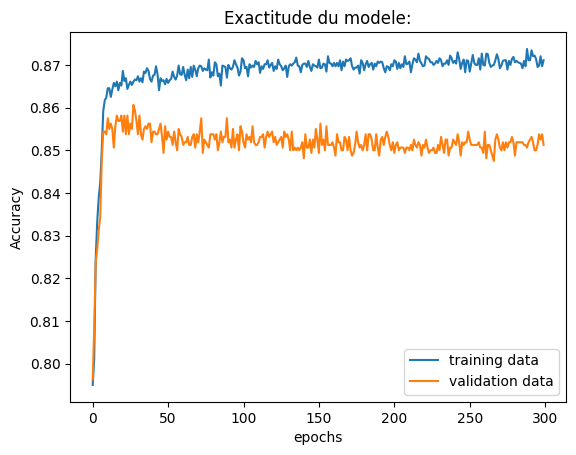

In [8]:
plt.plot(historique.history['accuracy'])
plt.plot(historique.history['val_accuracy'])
plt.title('Exactitude du modele:')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['training data','validation data'],loc='lower right')
plt.show()

In [18]:
rna_classif = Sequential()
rna_classif.add(Dense(units=8,kernel_initializer="glorot_uniform",activation='relu',input_dim=x_train.shape[1]))
rna_classif.add(Dense(units=6,kernel_initializer="glorot_uniform",activation='relu'))
rna_classif.add(Dense(units=4,kernel_initializer="glorot_uniform",activation='relu'))
rna_classif.add(Dense(units=1,kernel_initializer="glorot_uniform",activation='sigmoid'))
rna_classif.compile(optimizer="adam",loss = 'binary_crossentropy',metrics=["accuracy"])
rna_classif.fit(x_train, y_train,batch_size=10,epochs=30,class_weight=class_weights)
one_stat_result(rna_classif, x_train, y_train, x_test, y_test,b_seuil_label=True)

Epoch 1/30
800/800 [==============================] - 2s 2ms/step - loss: 0.1695 - accuracy: 0.7962
Epoch 2/30
800/800 [==============================] - 1s 2ms/step - loss: 0.1264 - accuracy: 0.7962
Epoch 3/30
800/800 [==============================] - 1s 2ms/step - loss: 0.1195 - accuracy: 0.7962
Epoch 4/30
800/800 [==============================] - 1s 2ms/step - loss: 0.1152 - accuracy: 0.7962
Epoch 5/30
800/800 [==============================] - 1s 2ms/step - loss: 0.1137 - accuracy: 0.8269
Epoch 6/30
800/800 [==============================] - 1s 2ms/step - loss: 0.1123 - accuracy: 0.8370
Epoch 7/30
800/800 [==============================] - 1s 2ms/step - loss: 0.1115 - accuracy: 0.8406
Epoch 8/30
800/800 [==============================] - 1s 2ms/step - loss: 0.1110 - accuracy: 0.8424
Epoch 9/30
800/800 [==============================] - 2s 2ms/step - loss: 0.1102 - accuracy: 0.8450
Epoch 10/30
800/800 [==============================] - 2s 2ms/step - loss: 0.1097 - accuracy: 0.8438

In [19]:
rna_classif = Sequential()
rna_classif.add(Dense(units=8,kernel_initializer="glorot_uniform",activation='relu',input_dim=x_train.shape[1]))
rna_classif.add(Dense(units=6,kernel_initializer="glorot_uniform",activation='relu'))
rna_classif.add(Dense(units=6,kernel_initializer="glorot_uniform",activation='relu'))
rna_classif.add(Dense(units=6,kernel_initializer="glorot_uniform",activation='relu'))
rna_classif.add(Dense(units=4,kernel_initializer="glorot_uniform",activation='relu'))
rna_classif.add(Dense(units=1,kernel_initializer="glorot_uniform",activation='sigmoid'))
rna_classif.compile(optimizer="adam",loss = 'binary_crossentropy',metrics=["accuracy"])
rna_classif.fit(x_train, y_train,batch_size=10,epochs=50,class_weight=class_weights)
one_stat_result(rna_classif, x_train, y_train, x_test, y_test,b_seuil_label=True)

Epoch 1/50
800/800 [==============================] - 3s 2ms/step - loss: 0.1639 - accuracy: 0.7929
Epoch 2/50
800/800 [==============================] - 2s 2ms/step - loss: 0.1334 - accuracy: 0.7962
Epoch 3/50
800/800 [==============================] - 2s 2ms/step - loss: 0.1304 - accuracy: 0.8058
Epoch 4/50
800/800 [==============================] - 2s 2ms/step - loss: 0.1290 - accuracy: 0.8160
Epoch 5/50
800/800 [==============================] - 2s 2ms/step - loss: 0.1274 - accuracy: 0.8180
Epoch 6/50
800/800 [==============================] - 2s 2ms/step - loss: 0.1264 - accuracy: 0.8242
Epoch 7/50
800/800 [==============================] - 2s 2ms/step - loss: 0.1250 - accuracy: 0.8278
Epoch 8/50
800/800 [==============================] - 2s 2ms/step - loss: 0.1230 - accuracy: 0.8284
Epoch 9/50
800/800 [==============================] - 2s 2ms/step - loss: 0.1177 - accuracy: 0.8416
Epoch 10/50
800/800 [==============================] - 2s 2ms/step - loss: 0.1131 - accuracy: 0.8472